# Import Libraries

In [250]:
import nltk
from nltk.stem.snowball import SnowballStemmer 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier
from nltk.probability import FreqDist
from matplotlib import cm
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV

# Obtain Data

In [150]:
df = pd.read_csv('../yelp_reviews.csv')
df.head()

,Category,Review
0,gyms,I come to this location all the time and love ...
1,gyms,This place is definitely not meant for kids. I...
2,gyms,BKB Gowanus might share the same name as they'...
3,gyms,Have been coming here for about 6 months since...
4,gyms,Rowing itself is a great workout but I did not...


# Scrub Data: Pre-Processing

In [151]:
df['Class'] = pd.get_dummies(df['Category'], drop_first=True)
df.head()

,Category,Review,Class
0,gyms,I come to this location all the time and love ...,1
1,gyms,This place is definitely not meant for kids. I...,1
2,gyms,BKB Gowanus might share the same name as they'...,1
3,gyms,Have been coming here for about 6 months since...,1
4,gyms,Rowing itself is a great workout but I did not...,1


In [152]:
gym_reviews = list(df[df['Class'] == 1]['Review'].values)
gym_tokens = []
for review in gym_reviews:
    gym_tokens.extend(nltk.word_tokenize(review))

In [153]:
barber_reviews = list(df[df['Class'] == 0]['Review'].values)
barber_tokens = []
for review in barber_reviews:
    barber_tokens.extend(nltk.word_tokenize(review))

In [154]:
stop_words = stopwords.words('english')
stop_words.extend(['.','i',",",'!','s','gym','barber','barbers', '...',"'s","n't",'(',')',"'m",'ve','i'])
filtered_gym_tokens = []
for word in gym_tokens:
    if word not in stop_words:
        filtered_gym_tokens.append(word)
filtered_barber_tokens = [] 
for word in barber_tokens:
    if word not in stop_words:
        filtered_barber_tokens.append(word)

In [155]:
stemmer = SnowballStemmer('english')
stemmed_gym = [stemmer.stem(word) for word in filtered_gym_tokens]
stemmed_barber = [stemmer.stem(word) for word in filtered_barber_tokens]

# Explore Data

In [156]:
gym_freq = FreqDist(stemmed_gym)
barber_freq = FreqDist(stemmed_barber)
gym_freq_words = [x[0] for x in gym_freq.most_common(25)]
gym_freq_counts = [x[1] for x in gym_freq.most_common(25)]
barber_freq_words = [x[0] for x in barber_freq.most_common(25)]
barber_freq_counts = [x[1] for x in barber_freq.most_common(25)]

[Text(0, 0, 'i'),
 Text(0, 0, 'haircut'),
 Text(0, 0, 'cut'),
 Text(0, 0, 'great'),
 Text(0, 0, 'hair'),
 Text(0, 0, 'year'),
 Text(0, 0, 'place'),
 Text(0, 0, 've'),
 Text(0, 0, 'time'),
 Text(0, 0, 'go'),
 Text(0, 0, 'shop'),
 Text(0, 0, 'get'),
 Text(0, 0, 'best'),
 Text(0, 0, 'the'),
 Text(0, 0, 'good'),
 Text(0, 0, 'look'),
 Text(0, 0, 'friend'),
 Text(0, 0, 'he'),
 Text(0, 0, 'alway'),
 Text(0, 0, 'guy'),
 Text(0, 0, 'barbershop'),
 Text(0, 0, 'come'),
 Text(0, 0, 'price'),
 Text(0, 0, 'got'),
 Text(0, 0, 'first')]

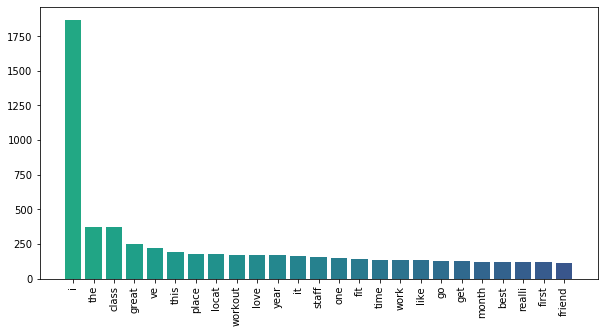

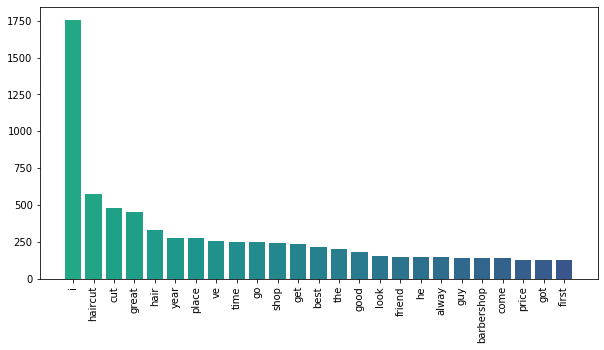

In [157]:
color = cm.viridis_r(np.linspace(.4,.8, 30))
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(gym_freq_words, gym_freq_counts, color=color)
ax.set_xticklabels(labels=gym_freq_words, rotation=90)
fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.bar(barber_freq_words, barber_freq_counts, color=color)
ax2.set_xticklabels(labels=barber_freq_words, rotation=90)

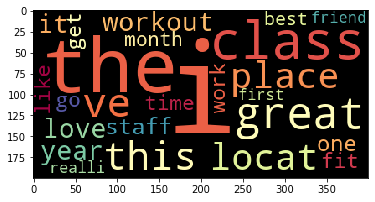

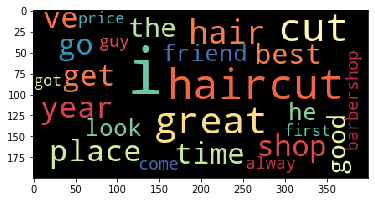

In [158]:
gym_freq_zipped = dict(zip(gym_freq_words, gym_freq_counts))
barber_freq_zipped = dict(zip(barber_freq_words, barber_freq_counts))
gym_wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(gym_freq_zipped)
barber_wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(barber_freq_zipped)
fig, ax = plt.subplots()
ax.imshow(gym_wordcloud)
fig2, ax2 = plt.subplots()
ax2.imshow(barber_wordcloud)

# Model Data

In [159]:
x = df['Review'].values
y = df['Class'].values

In [160]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=11, train_size = .2)

In [161]:
vectorizer = TfidfVectorizer(stop_words = stop_words)
vectorizer.fit(x_train)
tfidf_x_train = vectorizer.transform(x_train)
tfidf_x_test = vectorizer.transform(x_test)

In [188]:
nb_dict = {'alpha': np.array(range(250,300))/1000}
gs_nb = MultinomialNB()
gs_nb = GridSearchCV(gs_nb, nb_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_nb.fit(tfidf_x_train, y_train)
gs_nb.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.5s finished


{'alpha': 0.277}

In [189]:
nb = MultinomialNB(alpha=.277)
nb.fit(tfidf_x_train, y_train)
y_train_pred = nb.predict(tfidf_x_train)
y_test_pred = nb.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred))
print('Test F1 Score: ', f1_score(y_test, y_test_pred))

Train F1 Score:  0.998324958123953
Test F1 Score:  0.8950323974082075


[Text(0, 0.5, 'Barber'), Text(0, 1.5, 'Gym')]

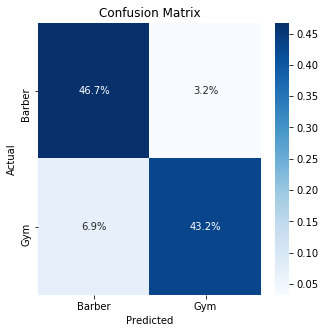

In [190]:
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Barber','Gym'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Barber','Gym'])

In [212]:
rf_dict = {'max_leaf_nodes': range(10,35,5), 'n_estimators': [500, 1000, 1250]}
gs_rf = RandomForestClassifier()
gs_rf = GridSearchCV(gs_rf, rf_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_rf.fit(tfidf_x_train, y_train)
gs_rf.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.9min finished


{'max_leaf_nodes': 15, 'n_estimators': 1250}

In [213]:
rf = RandomForestClassifier(max_leaf_nodes=15, n_estimators=1250)
rf.fit(tfidf_x_train, y_train)
y_train_pred_rf = rf.predict(tfidf_x_train)
y_test_pred_rf = rf.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_rf))

Train F1 Score:  0.9537480063795853
Test F1 Score:  0.8924302788844622


[Text(0, 0.5, 'Barber'), Text(0, 1.5, 'Gym')]

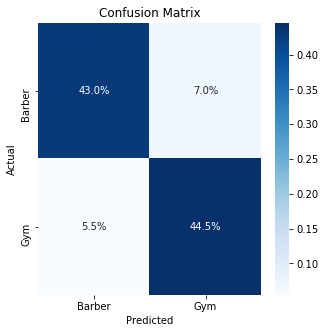

In [192]:
cm = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Barber','Gym'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Barber','Gym'])

In [249]:
gb = GradientBoostingClassifier(min_impurity_decrease=.2,n_estimators=150)
gb.fit(tfidf_x_train, y_train)
y_train_pred_gb = gb.predict(tfidf_x_train)
y_test_pred_gb = gb.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_gb))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_gb))

Train F1 Score:  1.0
Test F1 Score:  0.8771535580524344


In [257]:
vc = VotingClassifier(estimators=[('nb', nb), ('gb', gb), ('rf', rf)], voting='soft')
vc.fit(tfidf_x_train, y_train)
y_train_pred_vc = vc.predict(tfidf_x_train)
y_test_pred_vc = vc.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_vc))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_vc))

Train F1 Score:  1.0
Test F1 Score:  0.9142857142857143
